# Histéresis y avalanchas

### Raúl Reyes
### Rodrigo Leal

## Hamiltoniano

El sistema se modela con el modelo de Ising de campo aleatorio. El Hamiltoniano del sistema incorpora, además de la interacción de los espines vecinos, un término de la interacción de cada espín con el campo externo (que va a cambiar en el tiempo), y uno con un campo local aleatorio. 

$$ H = - \sum_{\langle i, j \rangle} J s_i s_j - \sum_{i}(H(t) + h_i)s_i $$

El campo aleatorio se escoge dentro de una distribución Gaussiana, con desviación estándar $R$:

$$ P(h) =  \frac{1}{\sqrt{2 \pi} R} e^{-h^2/2R^2} $$

Podemos reescribir al Hamiltoniano de la siguiente forma:

$$ H = - \sum_i \, \left[ \sum_{\langle j_i \rangle} J s_i s_j + (H(t) + h_i)s_i\right] $$

donde usamos la notación $\langle j_i \rangle$ para referirnos a los índices de los espines que son primeros vecinos de $s_i$.

Con la suma explícita corriendo sobre el índice $i$, es claro ahora que para un espín fijo $s_i$, la contribución a la energía total del sistema es:

$$ \begin{array}{c c l}
    H_i & = & - s_i \, \left[J \sum_{\langle j_i \rangle} s_j + H(t) + h_i \right] \\
    & = & - s_i T_i 
    \end{array}$$

## Evolución

Tomamos la temperatura igual a cero, y hacemos que todos los espines apunten hacia abajo. El campo externo se va a incrementar de $-\infty$ a $+\infty$, adiabáticamente (de manera infinitamente lenta), y posteriormente se va a disminuir en sentido contrario.

Originalmente todos los espines apuntan hacia abajo. El campo $H(t)$ es negativo y más grande en valor absoluto que $h_i$, (ésto es $H(t) + h_i < 0$) así que $H_i <0, \, \, \forall i$. 

Empezamos a incrementar el campo externo y buscamos cuándo es más favorable energéticamente que el espín $s_i$ se voltee. Ésto ocurre cuando $T_i$ se vuelve positivo, y por lo tanto $H_i$ se vuelve positivo. Entonces, $s_i$ cambia de signo y hace que $H_i$ sea de nuevo negativo. 

Cuando hacemos el camino inverso, disminuyendo el campo, $s_i$ apunta en un principio hacia arriba y ocurre lo contrario. $T_i$ originalmente es positivo, y cuando se vuelve negativo $s_i$ se voltea para hacer que $H_i$ se mantenga negativo.

## Avalanchas

El modelo que estamos utilizando da lugar de manera natural a avalanchas en las que, después de voltear un espín, a los vecinos les puede ser energeticamente favorable voltearse, sólo debido a la interacción entre espines, y con el campo externo fijo. 

En el caso en que los espines apuntan para abajo, y el campo magnético externo incrementa, en la implementación del modelo tenemos que buscar al primer espín que se voltea al incrementar $H(t)$. Éste espín tiene el máximo valor de $\sum s_j + h_i$. Llevamos el campo exactamente al valor necesario para voltearlo, $H(t) = -(J\sum s_j + h_i)$, y revisamos si hay espines que se pueden voltear por la interacción entre vecinos, esto es, si se produce una avalancha. Si no se produce, o si se produce y se acaban los vecinos que se voltean, recomenzamos y buscamos un nuevo valor máximo de $J\sum s_j + h_i$

Podemos resumir el algoritmo, para propagar una avalancha:
1. Buscamos el espín que inicia la avalancha, y que tiene el máximo valor de $J\sum s_j + h_i$.
2. Incrementamos $H(t)$ a menos el valor de este campo interno, y volteamos el espín $s_i$
3. Buscamos, entre todos los vecinos que no han sido volteados, los que tienen $J\sum s_j + h_i + H(t) = T_i > 0$, y los volteamos. Guardamos sus vecinos que no han sido volteados, y volvemos a empezar a buscar entre estos nuevos espines, hasta que ya no haya espines por voltear.
4. Repetimos desde el paso 1.

# Implementación

In [1]:
using PyPlot
using PyCall
using Interact
@pyimport matplotlib.animation as anim

INFO: Loading help data...


In [2]:
using Histeresis

La mayor parte del trabajo se ecuentra en nuestro módulo `Histeresis` (histeresis.jl). En este módulo definimos al tipo `MicroEstado`, a un par de funciones para crear un estado inicial y a una función que voltea a los espines. También tenemos una función que encuentra el 1er espín que se va a voltear incrementando o disminuyendo $H$, una que desarrolla una avalancha a partir de ese espín, y un par de funciones para seguir la evolución de la magnetización y de las matrices con los espines (que se van a animar).

### Animaciones

Para darnos una idea de qué es lo que hace el modelo. 

In [3]:
function anima_histeresis(edos, nombre::ASCIIString)
    fig = figure(figsize=(5,5))
    cuadros = [[imshow(edos[i], interpolation="none", vmin=-1, vmax=1)] for i=1:length(edos)]
    
    animacion = anim.ArtistAnimation(fig, cuadros, interval=200, blit=true) 
    animacion[:save](nombre*".mp4", extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])
end

function display_histeresis(nombre::ASCIIString)
    display("text/html", string("""<video autoplay controls><source src="data:video/x-m4v;base64,""",base64(open(readbytes,nombre*".mp4")),"""" type="video/mp4"></video>"""))
end

display_histeresis (generic function with 1 method)

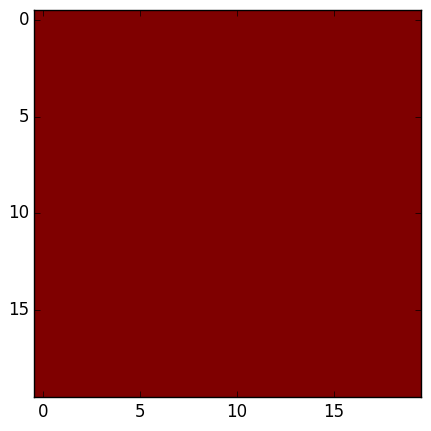

In [5]:
L = 20
R = 2
espin = -1
m = edo_inicial(L,R,espin)

H_set = 15

edos = microEstados_aumenta_H!(m,H_set,espin)
anima_histeresis(edos, "L20R2") ;

Nunca logramos quitar esta imagen molesta que escupe `imshow`... Abajo la animación:

In [6]:
display_histeresis("L20R2")

<source src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAS/BtZGF0AAACrQYF//+p3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE0NCByMjUzMyBjOGE3NzNlIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAxNSAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTMgbG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAgdZYiEABT//vfHT8Cm6Plmy51FPSEwitj6SCi9WOzQMnUAAAMAAAMADGj5q+cbg4CsoYAABIgAL06v8zetd53gAOgI5QNfVua6V/9YKAsyVzKr/EIO2DDQ9hG7+RxyIWzLchxDts+ALfl0wcHXrUV3nfCdWIutOyU4gkZvc4BBjDJhWPDjn0bFvije6Lppl6qETl7tMs+KPAqARL0EvnzOpmD8cYX1jY0eCq3FqEgjUSWZBPEJ8EKYhAoC+cVCV+L1teQk39mMnxy/nxIBp79CIIrrB5Yx+B1n+fl5Mved+Gen0KumT539d2H+vbmBFYDajOMR/nAHmRNgPv1J/CV/e8Bm6vtBvVP3SdjX1yNLq/VIalNNdqygdmzJqVHQ3d676ocMLcsiZtNWN4s7iFt9SII+mRXj82Ul4uwFjPZYVpoToBifP9MFYkyQZmJauutGzwEmun/9dKqDOylvYnpE49+oJXdDGRhOub+Ehy/s39ubf6g2Ab8c9sG8h6HmA2vnvPRVaFbW4elcBuU36EOm5v0bOiCG1f2TjQalQV+X1yRLq784wNyy9m9CwXDNpTxDlNZj4/xy0fiDFT4aTq6Qvyew56sOv4v5ply7DagKDpb4A8hrp/4kKqk32WfdreGdQwnQ5cVmN/GxXQrruMtAfHTwgXSU5CcX5ibxA+g8OZPMHUV2ETESL5RlnxgOrvd8/9r6iJBBF4GqpzbLAIhxe52RinNpo3nq9YcbZzyv2nEIolYzXrJtV4aJ0bJq4kJckB/kfJBvs26L1SEJzrAqS/MVVBS+aKHpMNcgIoLgI8RsomCyrkp/X512fAyDNox4NtedQCyE2R6YPdgXUuQLi0TF5sBHV/Wbf21YSBTXN40DTQvjZf9zMOLU/AKfZeo9RlHd32r9659T+AJZ5ysND+mJulV8JaFPcmstLnmKD5N+adrENUCu+2e0tv2VkwUbMbfj828OM9WEHuKpncyfnmOPcrVVwwDReYTQIOecGRBqUsBheP8mqVEDIjGx9LLSl+lTzFcynT8OL877z6qEbm2CJpvp9chtc3Bw9Afm0JXaN3KgRrDoIn8jhmuUu3A9D1cpa8uSwNkbhu84naW6zV7xNMXdlLeF6AZYri9+aXs3tNsAIpWH7QNwh6z7hUuxvcLqE4Gu20/vO/6KhA5fTqbUZkHXBB81pLujKPfabf3Agxd1kPzzpdcDq6kF4PXdQ2JcgfAsFFUCHmTlZ4sT//CLUzLclnBLjxSYxi0ILbLhbuSc3uyH6OA6ir7krOqx9+SG1K7Xoey8+ZYCmh5MWXmt1dU3Icii0gnM1ieOPZhp1bnR775mNW55epSiO9QPsnMzuL7Vqd//SQO33ufa3uAqzOTAWcIahR4/tBwn2zZmnrgcYV0IdEsDoC3EwIu5ALDgfypIf9n3f4WmCIpvhgoZc0TW8G4rYjMm1sp7RUmnFVI+mDw9m/O6dYlt7zhZ0Aar12g1u9emwsxK75N9f4RsexaM77KmrfLHUkr8tP40w+irvurLLyEm0lpmFzORPAUh2n9hP5kiRuXT7JyvhSiUWV3Y44cplZrJ0McOzvzqGawNe3Z3yaGjGdW1/QfM1hheZv/7Wpkvp7UNXwL4RWAD7klMXZa61OHHSRnETJyOu9AqPOfPKLP4RwzL5m8KfeVArKAFdZaSZQtSDA6Hw4QHGqNYPgAY2PnUfPFQP7xbDuyRObeDe3Cf29XsMIsP8Rwps0X3G4vn99qqekLp9qG73o11sadpYPR57+2P0yz2LhMevHbGK4byc/27p6lYyvwLD3cSwSwSsfZHaM/iUCV0fi6ic5dYnHV7Bgc5DGIFbzNgQxU1tu/h6s9HQ89lQHdjNgX0E5KHuXEcwUxLX4GY9vibSXUO/9SGWkiQDO7vwzTiwsarFPrVFa+B4PcYGOSinf5hMrl/svxwqM+3SX6joFosnjDef3hH5lnEDty11xXUoMlrB74FLKxUtjQPCo9U2F+fisv9J5qKNCvoRaK9vB+AfqBLoHhjSDkh2movltb/Rbxx7fdSR7htgPcG5mN85x5KTUeJRoaMTDgybpd92TKzYYmvcyHqCHkM8kKuvgd692DOim5oWdvu+lP1DzAccRz5NvEcAT4Bvkn/V7yXmMU90f+vVA8+zJYaZQjo6/0JBIGnt94/1auEdoGJUrYmbKmXRX4RRLWBzp8crKWd3yOixKRhsEADC3/UmlTp7jwJnvQj0C4h7dmB7+6/nvysqiTAOeORPbl0veh+PfHXvxw8bwarESnEvTPNmlLrMvgI1kiQPtKu1ZiV/2q1hyvDEEn+zIMQNFalTPdQk2YInUtAU6tkNpOt5QZnY13oujJz7SNzLnSyPYHWQlpn8vWRwxcuBORV6R1oVLflP8kBCsqCVRacjGXOcQGFK8+/D8jzR2FqRZTETa+9vrWJzVkNwrMcTgzOWm51qY96WVViqBDXLT9+WFpygF6V9p6svlJfEzsXxGaPU+cFpI8k66dhWvcNABPDL+rLlZGIEt5fD5hhTVVraS5s/96pwVQaPGVHCzonRs0bjzDomqV3TN+BifnYvnNecaGaAU1L1i1PhI5yD4RpIfxbqk2xu3If5gG/PPGgWKvSi5wuZ93d4NxX8HCl+XiHRuphJvXwI+N2r7HuxNbPSkIdGpkEcnkJMUn0mSIVI47phkONyS9r5mwsOmUOgzqKHAQamdVVgcvOR1h9qb3KcCVEx6bbuA11aaw9Ov9iewnsGLFJoS9XtMOXngyLWQAAAwASEQAAAktBmiRsQU/+1oywAVSq9awAbhukN34nmU/GTUsDmHjD2zBnRWsSkdzTtHjBU5KeAt1WeHR+F1rzouHAHy8m12Vtb8nuQoJS18/Ps0UaJz/MErWj//3UA0NeFSYkOQ+/0s+c/N8BbElczdJEFrxMWNqtO3gtshuPzJGrnlC4au5ZA6moJAs2M76sXvu1THsP3UnUeIOzgY9

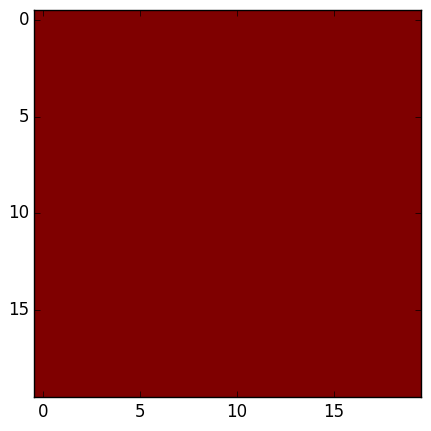

In [7]:
L = 20
R = 1
espin = -1
m = edo_inicial(L,R,espin)

H_set = 15

edos = microEstados_aumenta_H!(m,H_set,espin)
anima_histeresis(edos, "L20R1") ;

In [8]:
display_histeresis("L20R1")

<source src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAD9ZtZGF0AAACrQYF//+p3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE0NCByMjUzMyBjOGE3NzNlIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAxNSAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTMgbG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAaPZYiEABL//vet34FNwEDta7pXOLTLq5Q0PVH2lKZ4tkgAAAMAAAMAsBteBnzlzDhaCAAAlwAGIcv9DhpZbvmAHEpgUcoJPK/2q/5ZqDwCqr/MmoIl5xP0jB6Uu6FPj45phB9rRM60QbUziz98GzhUX7pttemIoU1loBC6qTfc/9kk6jioEfwP5RV0qtc/6Fof1IIa6h7uXcjdydPumdfQ+GzvQea7saVy6E3f0Dj+TzaM00ske+aMOzbsXsxy62rTgtRm63x1kAlVbydWAXHdhe0ixN12PreiVWyVHH2TWRZWDtzmjsYNxPPJA56ewLY60AJCXdHtXm4bhgjiVb+Apgd+FxiqsbFtUbMNsKGrE2pcF/pcyWUv75XmP1A1Br24ViLhP18Q/5B9llzP2WfN2ARvSIKehEZ73z6SeHdnRqLDd+mF7qgAdXvkN5ZuJRymJbT9+L6kyPgpdWDrQNwnxwCSvo29tXMg4F+eeLFWw+hgXEmGw5qd5iLeb4fef/ZxUzJC49/do3iuj3P9fSiWL1JJj/dlYM/zdT9hy1vi5r/u89bQJukvmBM8Abb16h0vrJaYaCfLH/Ne2J02I6lrIO8wlFdeMj+zBo4p4IlDyzI2ZwL2uL0LkA5S8WnYC8ANrMgD8mYKWuCJEFO5v2LLHIwf2suHW8nyQ4WpsKPgKeqm2ZlsQsoy0eepnnb9jxq2a9jN8PRrxxvlPMqO9H2ElHot86EPviYr+Fn+R0aFIGzYCgHW4KAUgBAfhWgZkWhjNeTSGQaXp6peh7SzqDXR60RYSkqQ+JiSc6rebA4vMqNhoYjEY03ePEBnyD2ZRUSJKWwdjRRPIsbo2U4PxbQxNj37sIbZTiSzDgKATcMzNvjJianp1ExWry++rL/rBzNzIl5fJhfXJYz5i45Xm+5M5kL0AzeGSC1iGwHWELKmCEv44ZbYxomYzIAsgYufyyCs0sFBvYY4LXBqkcYnNZvPB65G+qbE5nzdE6pkvzduksyKXy1f85T9Y/KPNf/9+nC73ptjaCYiVPxVMnzXkO6mzq1w0j6POIaemy3XBdNkIGS9A1ZRnNMxmTJsknoUs7Nmco3SD3rYbBUQCZJCTIGhSra422B9GuZ8/4766WK3ulOHHTYFJbi3nR/aHub2LHMwhUB3vjjV8qb5Np6rgRDL9cy7ewRXbZJga9uSbhqhlwn95NxRmKp4tlkFJfS6JkgmLM3xyRDPHMFMd/fWPizHxGuCHlXw+1d4S4iygAgfzhMfLP0Orv1U3PQEq3MMmziLGmCcZv4cUYrbA8mRu3zrc6YM9/7waYZHq8IeOWQkNmCJWEA0BU54H35Xap22IQ2OwDiVGCF8rk+O7XAhlJnQnOi2d7d/4yalaesixngmn2y2tG5ofjqF01+4MlIOrFgtn+FPwZLUYLZdcN5MF8mcF/Aa39A8o/F8HxcUCIYuLGkuI4px+5FXvyPnlXdrxWgg2siT8TzXXgnkq/dlsvIrXf1ZuAR5q3HHCm9UkTJFfX1aMTTOaoo65bPd55f6+e/Polmv1SyrsqXOM12OgPpBAXeJAt6uT3jQoHS9qEKDNqUOyTpTfypcHZkNicdf/BRboq/1RzIaQV/mOJyQqHqUAmFZv3F+NjU/eobubBNq6wSUCQ4GkHfMAQzhw5IP/Fnd08et/Xs/+EgaPTIzirJ6dtJ7xDrtBdleiKJtY4v0X+uVo6Ov38DxDcUVd13qsazAfN/BbOC4CqJvOQB/Kbt9LptB2oNTCubnYXU4zq3fm/FLMsP76x7kOY3GyJVaEND5oIM8yRR+cmSZPO67YrHfXfRskZCjQ3z+cXk1W5HZyREcUUVtudyRsLZ/pGXERF63xU2oWfrI0bwvio4sIaEKjXr9gCVlqTsavX5m7wp0if29WBVO5xBiHXThhhE7A2MzHjoDztRhzjV8ffvDy2yKEio5MJIQrxHj15wulpuERXyx3LiX5aLNT2okScXrnUoPFsClQCv7NZ972nNqWQDTQtfhd9mXUVS5THafYETuBwEutcEgrzwaiEDQ3nAjEE3DdIypXP3hd/qmnYKyODQJ3w9uAW3zqEUB7Syp6v+OG0DGvoaJ9CC5bDvubUZ8qKWA02aBF80+M2I52Nky/WxLNZToJ2+7kmYMoTu72TPdm+D4MVfIxhJldb9Tvhdj+nIm7FxwjaUAHLoZYQ33kY+OvrxTgojt80hZzTssOqde5732DYyFU/KARtuyAAADAwMAAAOAQZokbEEP/qpVABMek/Gq0AH9jniJrpj091sL5ZcrZLABEVNPeHeUMcHgLnW9J8NNeorvmsGRpH6CAMfWOU+ex2/BFvQWmMtY1uMKz99Ku9I9N6+MluZnzr45z1fRVfpyk0h0AKqBityXnY/MgHlXy/Bhwjc8wGpDXGsloUNE/6jMyI+PCxp5RUd3f97VbRqpQbKfg8Re8vCAjcgVAxn0/tjt/BUkImjL1e8EfdCcOMgmtY2cZK902Ox+hxNzM3K8gQLHSHbebDX5LOJQBBYyFoexkD3OJRL/FihfEGr2LTq0J3v5+RZ9P7/pUrasths1Xl38pjoXMaWftibp/2So57R9gDIJnsb2S7EtHRHIcDl25Tj05XzQtd0/B/0yurqC/cQZnzqrrGZGeqfpGC3I04e6pngYHu5nIsmo2m72InarSZJIIzvqfVQJMig0DzOsbcu2yErIRiVOUiZeYvbWSWuBGsuyJaz6hzp7gFC6IJVU8auMr/N4Y+j5Yjq5ninsvQGMceIETrdihkMhfXBq3cXL0TxWZLWueiSwqCqMrztKWlGNet0nHaFL5NSKKJrslCzRiGeffeYWjZWrq8Rd8OGl+hIQqSZeBU+ZShGOIfF9pqddDG2TMsPNbhI1JcCfqQvUbA8liMt8Qcy+deat+ryrGeDSnOsTthv253fTH26A5nIecyVSwkHbF1Flv4Rin6vYi6gXMQ/k8Ky2VufUcwtFUul

Para $R=2$, hay una buena cantidad de avalanchas pequeñas. Para $R=1$ hay unas pequeñas al principio, y una muy grande al final que voltea todo. Esto se debe a que $R$ mide el desorden del sistema, mientras más pequeño, más se parecen todos los espines.

### Distribuciones de avalanchas

Las animaciones arriba nos hacen preguntarnos cómo se ve la distribución de avalanchas al cambiar el parámetro $R$.

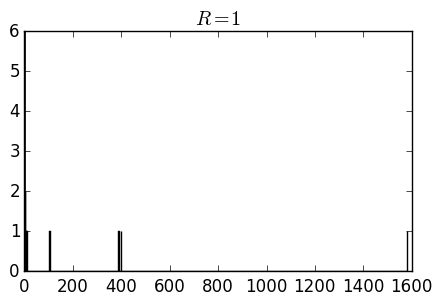

In [11]:
L = 50
R = 1
H_set = 15
espin = -1
m = edo_inicial(L,R,espin)

mag, hs, volteados = magnetizacion_aumenta_H!(m, H_set, espin) 

M = maximum(volteados)

figure(figsize=(5,3))
title(latexstring("R=$R"))
plt.hist(volteados, M, (1, M+1));

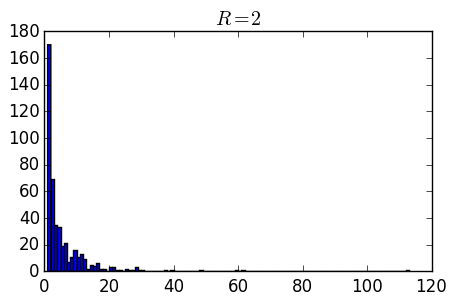

In [12]:
L = 50
R = 2
H_set = 15
espin = -1
m = edo_inicial(L,R,espin)

mag, hs, volteados = magnetizacion_aumenta_H!(m, H_set, espin) 

M = maximum(volteados)

figure(figsize=(5,3))
title(latexstring("R=$R"))
plt.hist(volteados, M, (1, M+1));

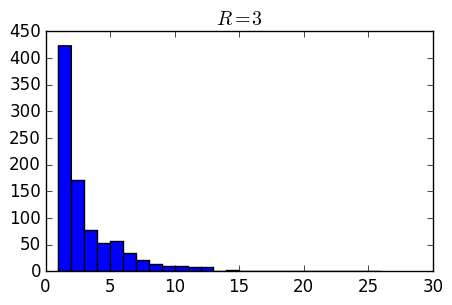

In [13]:
L = 50
R = 3
H_set = 15
espin = -1
m = edo_inicial(L,R,espin)

mag, hs, volteados = magnetizacion_aumenta_H!(m, H_set, espin) 

M = maximum(volteados)

figure(figsize=(5,3))
title(latexstring("R=$R"))
plt.hist(volteados, M, (1, M+1));

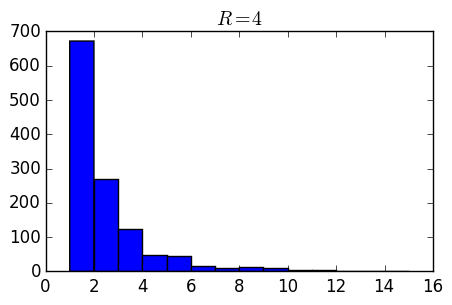

In [22]:
L = 50
R = 4
H_set = 15
espin = -1
m = edo_inicial(L,R,espin)

mag, hs, volteados = magnetizacion_aumenta_H!(m, H_set, espin) 

M = maximum(volteados)

figure(figsize=(5,3))
title(latexstring("R=$R"))
y, x = plt.hist(volteados, M, (1, M+1))[1:2] ;

La distribución parece tender a una distribución exponencial al incrementar $R$. Podemos hacer un cambio de variable para verificar ésto:

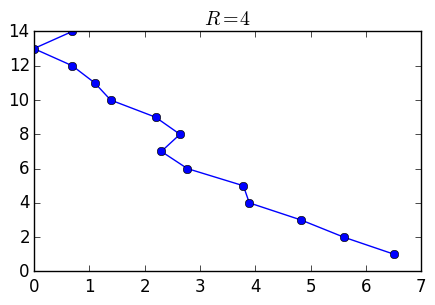

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x11c1f3450>

In [23]:
pop!(x)

figure(figsize=(5,3))
title(latexstring("R=$R"))
plot(log(y), x, "-o")

Tenemos aproximadamente una recta, la distribución es exponencial efectivamente.

### Curvas de histéresis

Nos interesa ahora ver el comportamiento del sistema cuando aumenta $H$, comparado con cuando disminuye.

In [24]:
# Una función para graficar un ciclo completo, con título, nombre de ejes y leyenda

function grafica_histeresis(mag1, hs1, mag2, hs2, N, R, H_set)
    figure(figsize=(7,5))
    xlabel(L"H/J") #J=1
    ylabel(L"M/N")
    title(latexstring("R = $R"))
    xlim(-H_set,H_set)
    ylim(-1.3,1.8)

    plot(hs1,mag1/N, ".", label="s=-1, H aumenta")
    plot(hs2,mag2/N, ".", label="s=+1, H disminuye")
    legend(loc="upper right")
end

grafica_histeresis (generic function with 1 method)

El ciclo es que $H$ aumenta hasta voltear todos los espines, y luego disminuye hasta voltear todos los espines.

In [25]:
L = 300
R = 0.7
espin = -1
m = edo_inicial(L,R,espin)

H_set = 5

# Empezamos con los espines apuntando hacia abajo, e incrementamos el campo H
@time mag1, hs1 = magnetizacion_aumenta_H!(m,H_set,espin)
# Espines apuntando hacia arriba, disminuye H
@time mag2, hs2 = magnetizacion_aumenta_H!(m,-H_set,-espin) ;

elapsed time: 1.46551563 seconds (203510144 bytes allocated, 23.50% gc time)
elapsed time: 1.426810773 seconds (191121984 bytes allocated, 52.80% gc time)


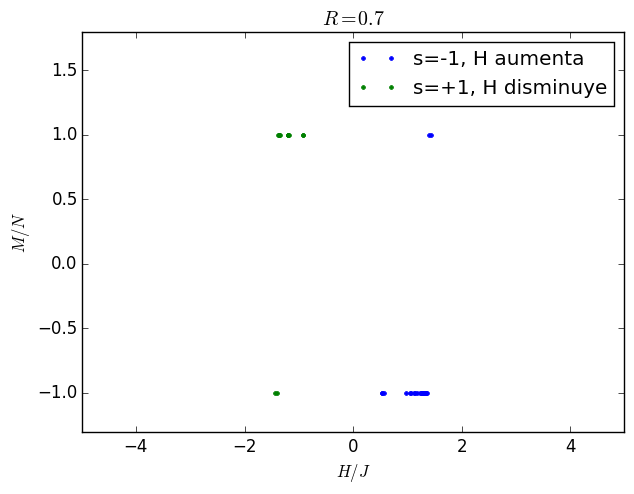

In [26]:
grafica_histeresis(mag1,hs1,mag2,hs2,m.N,R,H_set) ;

In [27]:
L = 300
R = 0.9
N = L^2
espin = -1
m = edo_inicial(L,R,espin)

H_set = 5

@time mag1, hs1 = magnetizacion_aumenta_H!(m,H_set,espin)
@time mag2, hs2 = magnetizacion_aumenta_H!(m,-H_set,-espin) ;

elapsed time: 10.076077212 seconds (364525296 bytes allocated, 7.08% gc time)
elapsed time: 10.988970668 seconds (363989948 bytes allocated, 8.37% gc time)


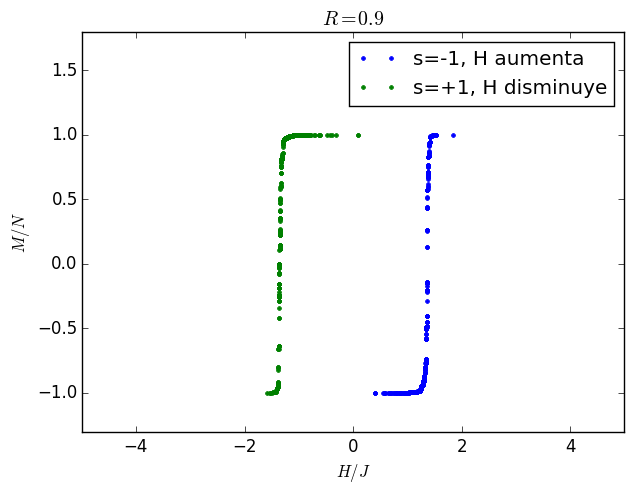

In [28]:
grafica_histeresis(mag1,hs1,mag2,hs2,m.N,R,H_set) ;

In [29]:
L = 300
R = 1.4
N = L^2
espin = -1
m = edo_inicial(L,R,espin)

H_set = 5
@time mag1, hs1 = magnetizacion_aumenta_H!(m,H_set,espin)
@time mag2, hs2 = magnetizacion_aumenta_H!(m,-H_set,-espin) ;

elapsed time: 139.916740861 seconds (4314321480 bytes allocated, 7.64% gc time)
elapsed time: 143.447326624 seconds (4351780672 bytes allocated, 7.44% gc time)


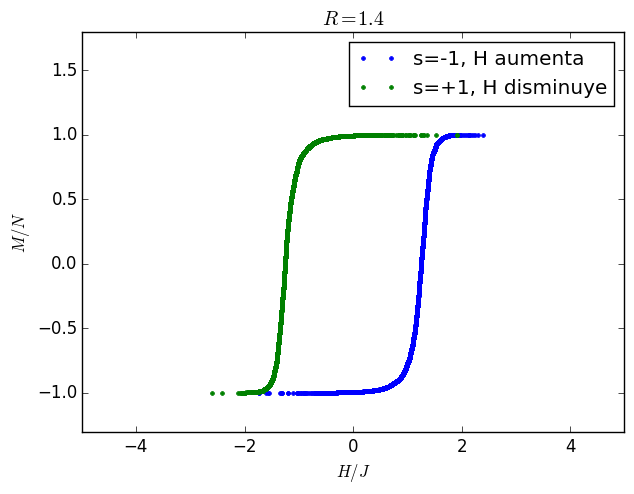

In [30]:
grafica_histeresis(mag1,hs1,mag2,hs2,m.N,R,H_set) ;

Constatamos que:
- La curva cuando el campo aumenta no es la misma que cuando disminuye. 
- Cuando $R$ es pequeño, hay una única avalancha grande y la magnetización aumenta bruscamente. Conforme $R$ aumenta, vemos más puntos entre el salto abrupto, hasta que obtenemos una curva continua, y con forma de S.

### Sliders, sólo la subida o sólo la bajada

A continuación un ejercicio ilustrativo en el que aprovechamos el módulo `Interact` para ver cómo se dibuja la curva de histéresis. Los botones `+1` y `-1` sirven para escoger si $H$ aumenta o disminuye respectivamente, y el slider sirve para escoger el máximo campo hasta el que se grafica.

In [ ]:
L = 50
R = 4
N = L^2
H_max = 15

fig = figure(figsize=(7,5))
xlabel(L"H/J") #J=1
ylabel(L"M/N")


@manipulate for H_set=-H_max:H_max, espin=[symbol("-1") => -1, symbol("+1") => 1]
    withfig(fig) do
        xlim(-H_max,H_max)
        ylim(-1,1)
        
        m = edo_inicial(L,R,espin)
        mag, hs = magnetizacion_aumenta_H!(m,H_set,espin)
        plot(hs,mag/N, ".")
    end
end